# Project 5 Introduction: Viscous Effects

In the previous projects, we have set up computational methods, source panel and vortex panel, for calculating lift and distributions of pressure assuming inviscid flow over an airfoil. This assumption prevented us from being able to find drag to due shear because shear relies on viscosity in a fluid. In this project, the viscous effects will be applied to the vortex panel method from the previous project to calculate the drag and more accurately find the total lift on the airfoil.

## Problem 1: Multi-element airfoil
Part 1 of this project focuses on our inviscid vortex panel method again but with more complex geometries. A second smaller airfoil will be added aft of the first to simulate the flow exhibited in a multi-body problem such as a wing with a deployed flap. Most of the code comes from the previously completed Project 4. The vortex panel method function has been adapted to accommodate the additional flap. The tasks completed in the problem include:

a) Run the vortex method solver on the main and flap airfoils together to solve pressure distribution with the main and flap discretized into 50 panels each, then 300 panels each with the panels plotted. The MainFoil_N=50.csv, FlapFoil_N=50.csv, MainFoil_N=300.csv, and FlapFoil_N=300.csv will be used for the airfoil geometry in this section.

b) Plot the pressure distribution for the case solved with 50 panels on each airfoil and the case solved with 300 panels on each airfoil.

c) Solve the pressure distribution for a 23012 main and flap airfoil discretized into 150 panels each with the flap deployed at 10, 20, and 30 degrees. The NACA23012_MainFoil.csv and NACA23012_FlapFoil.csv will be used for the part.

d) Plot the pressure distributions obtained in the previous step and compare the plots to empirically obtained data for the same cases with the same airfoil.

e) Calculate and compare the coefficients of lift obtained from each flap setting.



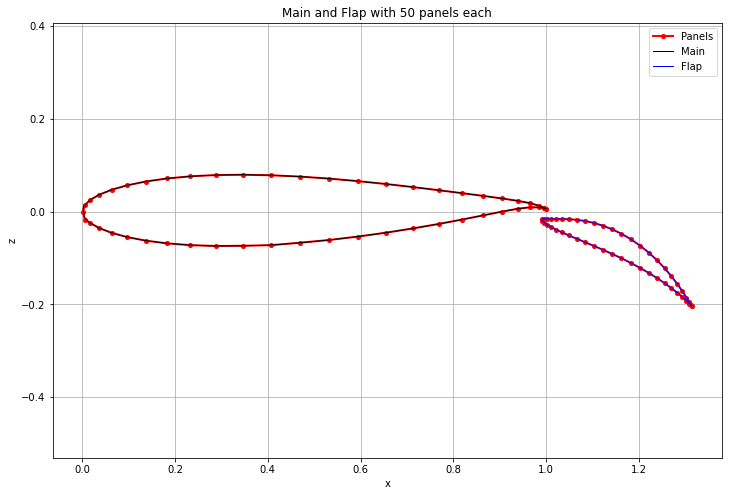

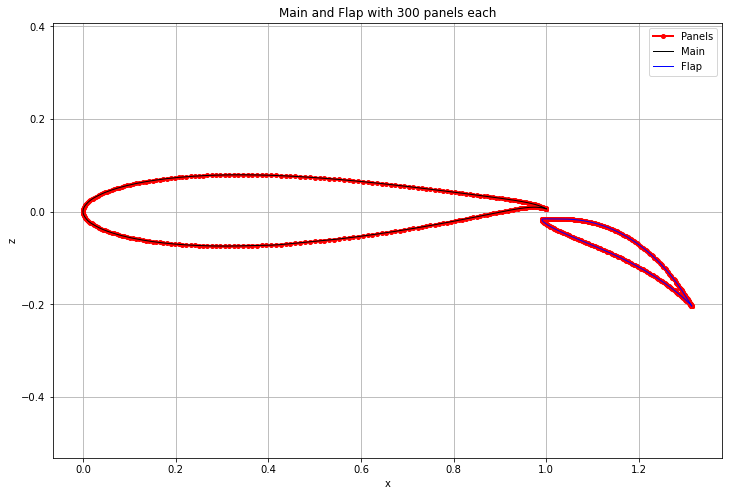

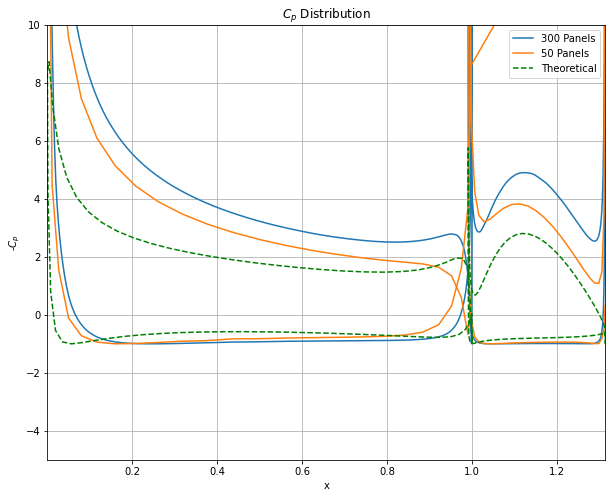

In [1]:
import math
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate, linalg
import os

class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

# discretize geometry into panels
def define_panels(x, y, N):
    stop = len(x)/2
    stop_low = math.floor(stop)
    stop_high = math.ceil(stop)

    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    y_center = (y.max() + y.min()) / 2.0  # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, N+1)  # array of angles
    x_circle = x_center + R * numpy.cos(theta)  # x-coordinates of circle
    y_circle = y_center + R * numpy.sin(theta)  # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends)  # y-coordinate of panels end-points

    # compute y-coordinate of end-points by projection
    I = 0

    for i in range(N):
        if i < math.floor(N/2):
            for I in range (stop_low):
                if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                    break
                else:
                    continue
            a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
            b = y[I + 1] - a * x[I + 1]
            y_ends[i] = a * x_ends[i] + b          
        if i > math.ceil(N/2):
            for I in range (len(x) - 2, stop_high, -1):
                if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                    break
                else:
                    continue
            a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
            b = y[I + 1] - a * x[I + 1]
            y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]

    for i in range(N):
        if i > N:
            break
        if y_ends[i] > max(y):
            x_ends = numpy.delete(x_ends, i)
            y_ends = numpy.delete(y_ends, i)
            N = len(x_ends) - 1
        i += 1
    
    for i in range(N):
        if y_ends[i] < min(y):
            x_ends = numpy.delete(x_ends, i)
            y_ends = numpy.delete(y_ends, i)
            N = len(x_ends) - 1
        i += 1

    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians

def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size + 1, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2 

def vortex_method(main, flap, panel_num):
    # load geometry and create panels for main airfoil
    main_airfoil = main
    naca_filepath = os.path.join('Data', f'{main_airfoil}.csv')
    with open(naca_filepath, 'r') as infile:
        x_main, y_main = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
    
    main_panels = define_panels(x_main, y_main, panel_num)
    
    # plot main panels
    plt.figure(figsize=(12, 8))
    plt.plot(numpy.append([panel.xa for panel in main_panels], main_panels[0].xa),
                numpy.append([panel.ya for panel in main_panels], main_panels[0].ya),
                linestyle='-', linewidth=2, marker='o', markersize=4, color='r', label='Panels') 
    plt.axis('equal')
    
    # load geometry and create panels for flap airfoil
    if type(flap)==type(numpy.array([])):
        x_flap = flap[0]
        y_flap = flap[1]
    else:
        flap_airfoil = flap
        naca_filepath = os.path.join('data', f'{flap_airfoil}.csv')
        with open(naca_filepath, 'r') as infile:
            x_flap, y_flap = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
        
    flap_panels = define_panels(x_flap, y_flap, panel_num)
    
    # plot flap panels
    plt.plot(numpy.append([panel.xa for panel in flap_panels], flap_panels[0].xa),
                numpy.append([panel.ya for panel in flap_panels], flap_panels[0].ya),
                linestyle='-', linewidth=2, marker='o', markersize=4, color='r') 

    # analyze all panels together
    panels = numpy.concatenate((main_panels, flap_panels))
    x = numpy.concatenate((x_main, x_flap))
    y = numpy.concatenate((y_main, y_flap))
    
    freestream = Freestream(u_inf=10.0, alpha=7.0)
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
 
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)

    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)
    # store source strength on each panel
    for i, panel in enumerate(panels):
        panel.sigma = strengths[i]
    # store circulation density
    gamma = strengths[-1]
    # tangential velocity at each panel center.
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    
    # compute the chord and lift coefficient
    c = abs(max(panel.xa for panel in panels) -
            min(panel.xa for panel in panels))
    cl = (gamma * sum(panel.length for panel in panels) /
        (0.5 * freestream.u_inf * c))
    return panels, x, y, cl

main = 'MainFoil_N=50'
flap = 'FlapFoil_N=50'
panels, x_panel, y_panel, cl = vortex_method(main, flap, 50)
plt.title('Main and Flap with 50 panels each')
plt.plot(x_panel[0:(int(len(x_panel)/2))-1], y_panel[0:(int(len(x_panel)/2))-1], color='k', linestyle='-', linewidth=1, label='Main')
plt.plot(x_panel[(int(len(x_panel)/2)):-1], y_panel[(int(len(x_panel)/2)):-1], color='b', linestyle='-', linewidth=1, label='Flap')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.grid()
plt.show()

cps_50 = []
xcs_50 = []
for panel in panels:
    cps_50.append(-panel.cp)
    xcs_50.append(panel.xc)

main = 'MainFoil_N=300'
flap = 'FlapFoil_N=300'
panels, x_panel, y_panel, cl = vortex_method(main, flap, 300)
plt.title('Main and Flap with 300 panels each')
plt.plot(x_panel[0:(int(len(x_panel)/2))-1], y_panel[0:(int(len(x_panel)/2))-1], color='k', linestyle='-', linewidth=1, label='Main')
plt.plot(x_panel[(int(len(x_panel)/2)):-1], y_panel[(int(len(x_panel)/2)):-1], color='b', linestyle='-', linewidth=1, label='Flap')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.grid()
plt.show()

cps_300 = []
xcs_300 = []
for panel in panels:
    cps_300.append(-panel.cp)
    xcs_300.append(panel.xc)

cpmain_theoretical_filepath = os.path.join('Data', f'Cp_Main_theoretical.csv')
with open(cpmain_theoretical_filepath, 'r') as infile:
    x_main_theo, y_main_theo = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
cpflap_theoretical_filepath = os.path.join('Data', f'Cp_Flap_theoretical.csv')
with open(cpflap_theoretical_filepath, 'r') as infile:
    x_flap_theo, y_flap_theo = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
# plot pressure distributions for each case
plt.figure(figsize=(10, 8))
plt.plot(xcs_300, cps_300, label='300 Panels')
plt.plot(xcs_50, cps_50, label='50 Panels')
plt.plot(x_main_theo, -y_main_theo, linestyle='--', color='g', label='Theoretical')
plt.plot(x_flap_theo, -y_flap_theo, linestyle='--', color='g')
plt.title(r'$C_p$ Distribution')
plt.xlabel('x')
plt.ylabel(r'-$C_p$')
plt.xlim([min(xcs_300), max(xcs_300)])
plt.ylim([-5, 10])
plt.legend()
plt.grid()
plt.show()

### Problem 1a-b: Results

The pressure distribution graph above shows how the panel method with differing discretizations compare to the theoretical solution. The difference between the panel method and theoretical solutions is relatively large with some pressure values being twice as large or larger than the theoretical solution. The expectation was that as the panel number increases, the solution would converge towards the theoretical solution. In this case, it appears that the increased number of panels generally diverges from the theoretical solution. This is the opposite of the expectation. The graphs do contain all of the same features as the theoretical solution. The reason for the divergence from the theoretical solution is unclear. It is assumed that the theoretical solution takes an inviscid flow assumption like the vortex panel method. The two individual discretized cases also exhibit relatively large differences in values but are more similar to each other than the theoretical solution. This vortex method graph shows that the results are generally not close enough to the theoretical values to be considered correct, unless the theoretical solution is incorrect and the vortex method actually is the correct one in this case.

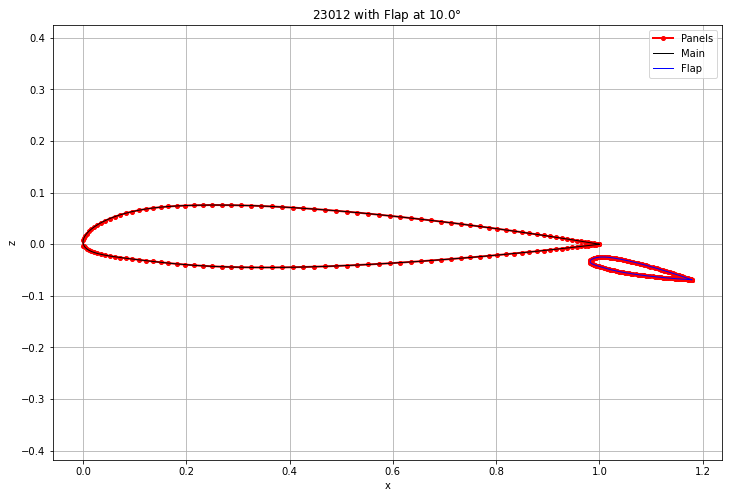

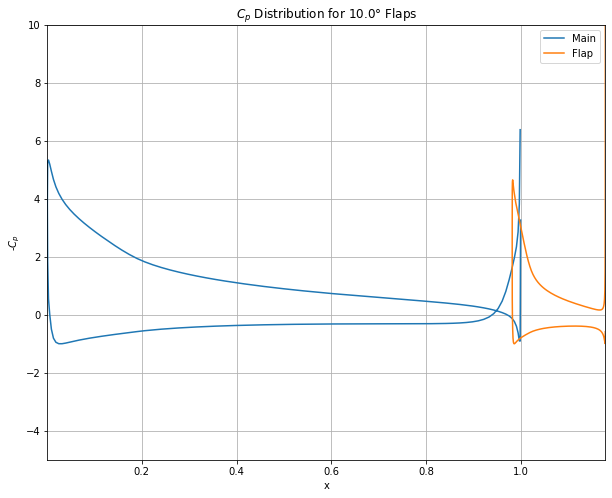

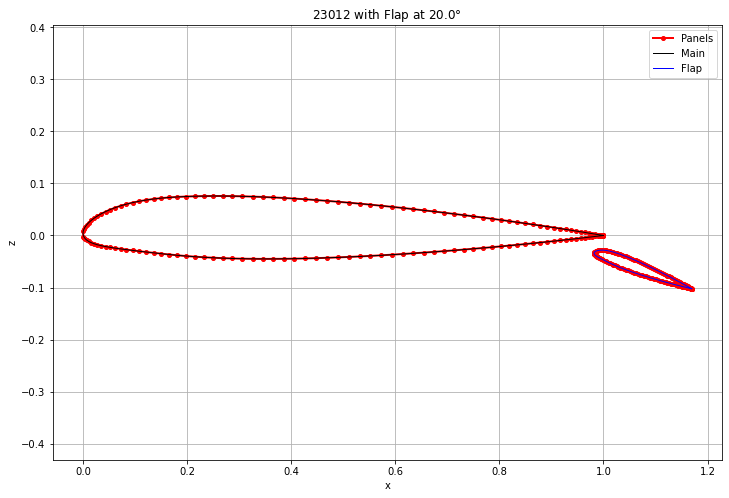

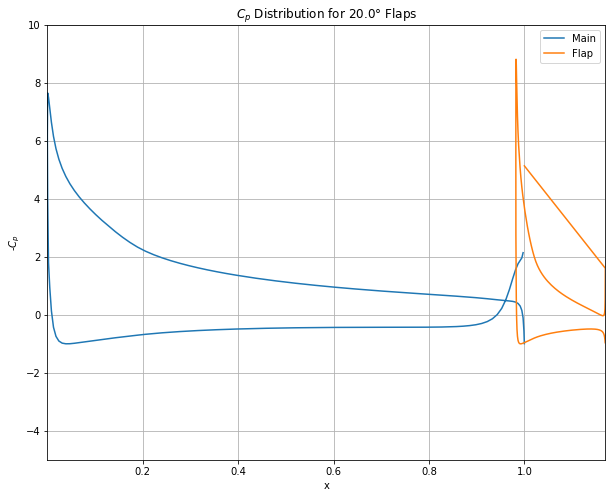

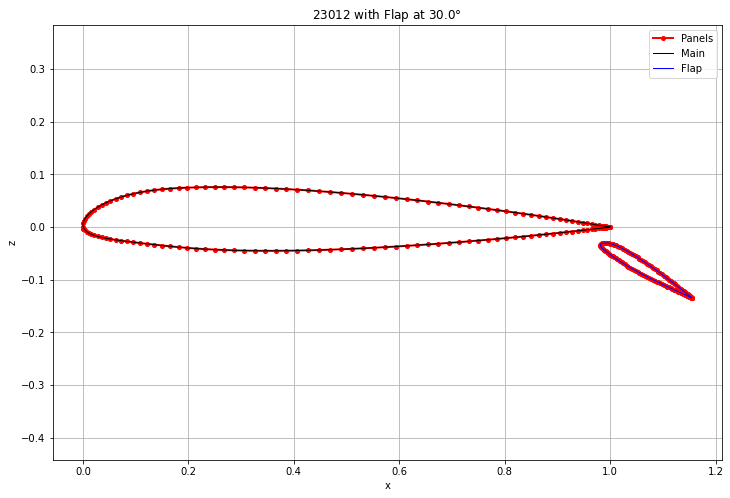

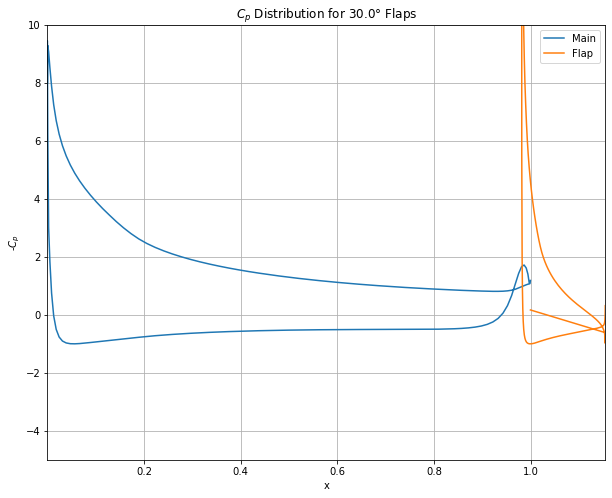

   Flap setting  Calculated C_l
0         -10.0        1.626106
1         -20.0        2.087942
2         -30.0        2.425354


In [4]:
# NACA 23012
from IPython.display import Image

def rotate_flap(x_flap, y_flap, rad):
    x = x_flap
    y = y_flap
    # rotation matrix
    R = numpy.array(((numpy.cos(rad), -numpy.sin(rad)),(numpy.sin(rad), numpy.cos(rad))))

    # move the coords over to the origin first
    leading_edge_x = min(x)
    leading_edge_y = y_flap[numpy.where(x==min(x))[0][0]]
    for i in range(len(x)):
        x[i] -= leading_edge_x
        if leading_edge_y < 0:
            y[i] -= leading_edge_y  
        elif leading_edge_y > 0:
            y[i] += leading_edge_y 
    coords = numpy.vstack((x, y))
    rotated = numpy.matmul(R, coords)
    x_rotated = rotated[0]
    y_rotated = rotated[1]
    
    # moving the coords back after rotation
    for i in range(len(x_rotated)):
        x_rotated[i] += leading_edge_x
        if leading_edge_y < 0:
            y_rotated[i] += leading_edge_y  
        elif leading_edge_y > 0:
            y_rotated[i] -= leading_edge_y 
    return x_rotated, y_rotated

# load geometries
main = 'Data/NACA23012_MainFoil.csv'
with open(main, 'r') as infile:
    x_main, y_main = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')


# negative angles for clockwise rotation
flap_setting_deg = [-10.0, -20.0, -30.0]
flap_setting_rad = []
for deg in flap_setting_deg:
    flap_setting_rad.append(numpy.radians(deg))

cl_list = []
for i in range(3):
    
    flap = 'Data/NACA23012_FlapFoil.csv'
    with open(flap, 'r') as infile:
        x_flap, y_flap = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
        
    x_flap_rotated, y_flap_rotated = rotate_flap(x_flap, y_flap, flap_setting_rad[i])
    flap_rotated = numpy.vstack((x_flap_rotated, y_flap_rotated))
    panels, x_panel, y_panel, cl = vortex_method('NACA23012_MainFoil', flap_rotated, 150)
    cl_list.append(cl)
    
    plt.plot(x_panel[0:(int(len(x_panel)/2))-1], y_panel[0:(int(len(x_panel)/2))-1], color='k', linestyle='-', linewidth=1, label='Main')
    plt.plot(x_panel[(int(len(x_panel)/2)):-1], y_panel[(int(len(x_panel)/2)):-1], color='b', linestyle='-', linewidth=1, label='Flap')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'23012 with Flap at {-flap_setting_deg[i]}' + r'$\degree$')
    plt.legend()
    plt.grid()
    plt.show()
    
    cps = []
    xcs = []
    for panel in panels:
        cps.append(-panel.cp)
        xcs.append(panel.xc)

    # plot pressure distributions for each case
    plt.figure(figsize=(10, 8))
    plt.plot(xcs[0:(int(len(xcs)/2)-1)], cps[0:(int(len(xcs)/2)-1)], label='Main')
    plt.plot(xcs[int(len(xcs)/2):-1], cps[int(len(xcs)/2):-1], label='Flap')
    plt.title(r'$C_p$ Distribution' + f' for {-flap_setting_deg[i]}' + r'$\degree$ Flaps')
    plt.xlabel('x')
    plt.ylabel(r'-$C_p$')
    plt.xlim([min(xcs), max(xcs)])
    plt.ylim([-5, 10])
    plt.legend()
    plt.grid()
    plt.show()
    
d = {'Flap setting': flap_setting_deg, 'Calculated C_l': cl_list}
print(pd.DataFrame(d))

![title](img/10.jpg)

10 degree flap deployment

![title](img/20.jpg)

20 degree flap deployment

![title](img/30.jpg)

30 degree flap deployment


### Problem 1c-e: Results

It was difficult finding plots in the NASA Technical Report that matched my results. Besides the few accidental extraneous points on my plots that caused some distorted curves, the calculated pressure distribution curves and the reported curves share a few noticeable similarities and exhibit some differences. I was not able to have my pressure distribution rotated on the flap section as depicted in the NASA report. 

For the 10 degree case, the recovery region matches fairly well with a gently slope. My results had a much higher peak on the leading edge of the flap and main airfoil and the lines for the upper and lower surface of the main airfoil cross the x axis while they do not in the NASA report. 

In the 20 degree case, there is an erroneous point that messes up the distribution curve. It most closely resembles the report case chosen due to the sharp peak on the main airfoil. The peak on the flap is much higher in my results than those depicted in the NASA report. Also, my results show that the upper and lower surfaces have some flow separation at the trailing edge where the pressures cross the x-axis. The report and the vortex panel results generally agree on the overall pressure distribution shapes on the main and flap airfoils. 

Finally, in the 30 degree flap case, the sharp high peaks on the main and flap airfoils resemble those seen in my results. My results differ in that the pressure approaches zero at the trailing edge of the main airfoil. They also show that the maximum suction point on the flap is higher than the main airfoil which is a bit counterintuitive since the main airfoil is larger but it is also possible that the large angle of attack is causing this larger suction point.

As tabulated in the flap setting vs coefficient of lift table above, the total coefficient of lift for the multi-body system of main airfoil and flap increases as the flap setting increases. This matches our expectations. The main airfoil and flap together can be thought of as one large airfoil. When the flap is deployed, the overall camber and angle of attack for this system increase. Increased camber and angle of attack result in an increased lift. This is the purpose of flaps. If the coefficient of drag was calculated for this system, it would be observed that the drag also increases as the lift increases.

Some weaknesses of this method include the fact that it does not take viscosity into effect and that computational workload increases dramatically as the number of panels increases. Viscosity would play a big role in the space between the main airfoil and the flap as the boundary layers interact with each other.

## Problem 2: Viscous/Inviscid Interaction

In this problem, we finally begin to take viscosity into consideration when calculating pressure distributions and lift. The source panel method will be adapted for this case. We will be calculating the boundary layer displacement thickness iteratively to come upon an airfoil surface that acts equivalently to that which is acted upon by viscous flow.

The Vivi tool used for this problem can be summarized as executing the following:
1) Load airfoil surface geometry from data file
2) Generate Polar and Surface Coefficient of Pressure distribution using airfoil geometry in XFOIL
3) Store geometry and surface pressure distribution in dfs dictionary
4) Calculate velocity at each surface point using Bernoulli relation with coefficient of pressure at each point and freestream velocity
5) Calculate displacement thickness with Blasius shape factor H for flat plate case
6) Generate new surface by adding displacement thickness
7) Calculate shear stress at each surface point using shear stress
8) Store displaced surface geometry for next iteration

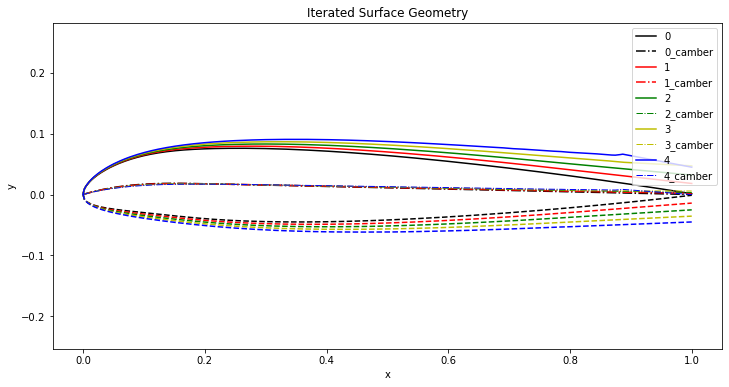

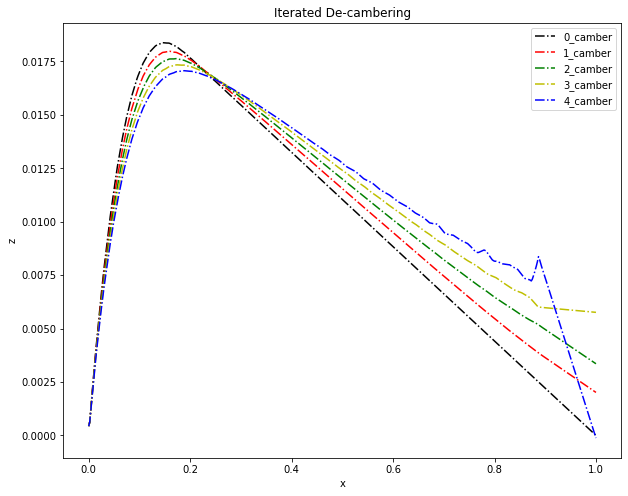

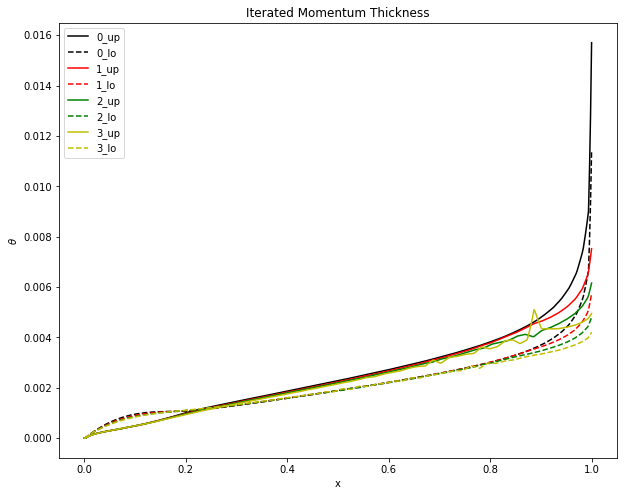

In [5]:
# Project 5
import math
import pyxfoil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import vivi

def MsesSplit(x, y):
	"""Split MSES format into upper and lower surfaces.  Find split from
	x geometry coordinates, split y at this index.  Return y split into
	two sets: upper and lower
	x --> MSES x coordinates
	y --> Any other MSES parameter (e.g. x/c, z/c, Cp, etc)
	"""
	#Get index of leading edge on upper surface
	iLE = FindLE(x)
	#Split upper and lower surface, reverse order upper surface
	up = y[iLE::-1]
	lo = y[iLE+1:]
	return up, lo

def MsesInterp(xout, xmses, ymses):
	"""Split MSES format data into upper and lower surfaces.  Then
	interpolate data to match given xout vector.
	xout  --> desired x locations
	xmses --> original x MSES data
	ymses --> original x/c, z/c, Cp, etc MSES data
	"""
	xup_mses, xlo_mses = MsesSplit(xmses, xmses)
	yup_mses, ylo_mses = MsesSplit(xmses, ymses)
	yup = np.interp(xout, xup_mses, yup_mses)
	ylo = np.interp(xout, xlo_mses, ylo_mses)
	return yup, ylo

def FindLE(X):
	"""Return index dividing upper and lower surface given MSES format
	geometry.
	MSES files start at rear of airfoil, and x diminishes until the leading
	edge, where it then increases back to the trailing edge.  This code finds
	the transition where x goes from decreasing to increasing.
	X --> MSES x coordinates
	"""
	xold = X[0]
	for i, x in enumerate(X[1:]):
		if x >= xold:
			#If current x greater/equal to prev x, x is increasing (lower surf)
			return i #return index of Leading Edge (divides upper/lower surfs)
		else:
			#If current x less than prev x, x still diminishing (upper surf) 
			xold = x



foil='23012'
naca = True
alpha = 0
currentiter = 0
pyxfoil.GetPolar(foil, naca, alpha, Re = 0)
foil = 'naca23012'
Vinf = 1
mu=1.79E-5
rho=1.225
naca= True

dfs = vivi.VIvI(foil, alpha, currentiter, Vinf, mu, rho)
path = 'Data/naca23012/naca23012.dat'
dfmses=pyxfoil.ReadXfoilAirfoilGeom(path)

plot.figure("geometry", figsize=(12,6))
plot.title('Iterated Surface Geometry')
plot.axis('equal')

colors = ['k', 'r', 'g', 'y', 'b']
plot.xlabel('x')
plot.ylabel('y')
plot.plot(dfs['up']['x'], dfs['up']['z'], 'k', label=0)
plot.plot(dfs['lo']['x'], dfs['lo']['z'], 'k', linestyle='--')

avg = (dfs['up']['z']+dfs['lo']['z'])/2
plot.plot(dfs['up']['x'], avg, 'k', label='0_camber', linestyle='-.')

plot.figure('cambers', figsize=(10, 8)) # include in the separate graph for camber lines
avg = (dfs['up']['z']+dfs['lo']['z'])/2
plot.plot(dfs['up']['x'], avg, 'k', label='0_camber', linestyle='-.')
plot.title('Iterated De-cambering')
plot.xlabel('x')
plot.ylabel('z')

plot.figure('geometry') # back to the displaced geometries plot
plot.plot(dfs['up']['x'], dfs['up']['zdisp'], 'r', label=1)
plot.plot(dfs['lo']['x'], dfs['lo']['zdisp'], 'r', linestyle='--')

avg = (dfs['up']['zdisp']+dfs['lo']['zdisp'])/2
plot.plot(dfs['up']['x'], avg, 'r', label='1_camber', linestyle='-.')

plot.figure('cambers') # include in the separate graph for camber lines
plot.plot(dfs['up']['x'], avg, 'r', label='1_camber', linestyle='-.')

#x-vector is same length as VIvI data, bounded by geometry loaded from file
x = np.linspace(min(dfs['up']['x']), max(dfs['up']['x']), len(dfs['up']['theta']))
plot.figure("thickness", figsize=(10, 8)) #plot momentum thickness
plot.title('Iterated Momentum Thickness')
plot.xlabel('x')
plot.ylabel('$\\theta$')
plot.plot(x, dfs['up']['theta'], label='0_up', color='k')
plot.plot(x, dfs['lo']['theta'], label='0_lo', color='k', linestyle='--')


currentiter += 1


for i in [1, 2, 3]:
	dfs = vivi.VIvI(foil, alpha, currentiter, Vinf, mu, rho)
	path = 'Data/naca23012/naca23012.dat'
	dfmses=pyxfoil.ReadXfoilAirfoilGeom(path)

	plot.figure("geometry")
	plot.plot(dfs['up']['x'], dfs['up']['zdisp'], color=colors[i+1], label=i+1)
	plot.plot(dfs['lo']['x'], dfs['lo']['zdisp'], linestyle='--', color=colors[i+1])

	avg = (dfs['up']['zdisp']+dfs['lo']['zdisp'])/2
	plot.plot(dfs['up']['x'], avg, color=colors[i+1], label=f'{i+1}_camber', linestyle='-.', linewidth=1)

	plot.figure('cambers') # include in the separate graph for camber lines
	plot.plot(dfs['up']['x'], avg, color=colors[i+1], label=f'{i+1}_camber', linestyle='-.')

	#x-vector is same length as VIvI data, bounded by geometry loaded from file
	x = np.linspace(min(dfs['up']['x']), max(dfs['up']['x']), len(dfs['up']['theta']))
	#plot momentum thickness
	plot.figure('thickness')
	plot.plot(x, dfs['up']['theta'], color=colors[i], label=f'{i}_up')
	plot.plot(x, dfs['lo']['theta'], color=colors[i], label=f'{i}_lo', linestyle='--')

	currentiter += 1
plot.figure('geometry')
plot.legend()
plot.figure('cambers')
plot.legend()
plot.figure('thickness')
plot.legend()


### Problem 2.1: Results

Iterating on the geometry of the airfoil has several clear characteristics. The geometry shows little or no change on the leading edge. The geometry shows an increasing surface displacement going from the leading to the trailing edge. In the second graph, it is evident that the momentum thickness slowly converges. This does not mean that the displaced suface geometry but rather that the rate at which the displaced surface expands away from the previous surface decreases.

The second graph demonstrates the concept of de-cambering. With each iteration, the overall camber trends towards becoming more flat. The maximum camber decreases with each iteration and the curve slowly flatens out. Analyzing the first and second graph also reveals that with each iteration, in the aft portion of the airfoil, the displaced surface moves away from the original geometry faster on the top rather than on the bottom. Also, near the leading edge, the displaced surface moves away from the original geometry faster on the bottom rather than on the top. These two observations explain how the camber line points are decreasing near the front and increasing in the back.


## Problem 2.2
This section requires the calculation of the coefficient of drag and lift on the 23012 airfoil. To acquire the coefficient of lift, we must simply run xfoil on the geometry. However, xfoil cannot calculate a coefficient of drag with no viscous effects so we calculate this ourselves using the momentum thickness and a relation between the momentum thickness and the surface shear force. The coefficient of drag and lift are calculated in this way for the 3rd Vivi iteration performed in the previous problem. The viscous xfoil simulation will also be run on the original 23012 geometry and the 3rd Vivi iteration for comparison.

In [39]:
# Problem 2.2

def MomThickness(x, u, Vinf, mu=1.79E-5, rho=1.225):
    # this is an edited version that doesn't run into the errors that the vivi version does
    """Compute momentum thickness at a given x-location along chord from
    equation derived by applying Blausius solution for flat plat to
    von Karmen integral relation for boundary layer.
    x --> coordinates along chord
    u --> surface velocity distribution as f(x) (from pot. flow soln)
    """
    #Compute momentum thickness at each X location (via von Karman relation)
    n = len(x) #number of x-locations
    c = max(x) - min(x)
    mom_thk = np.zeros(n) #initialize momentum thickness vector
    #Loop through each x-location
    for i in range(n):
        Rex = rho*Vinf*x/mu
        mom_thk = 0.664*x/np.sqrt(Rex)
    return mom_thk
pressfile = 'Data/naca23012_3/naca23012_3_surfCP_Re0.00e+00a0.0.dat'
xCp = pyxfoil.ReadXfoilSurfPress(pressfile)

u = vivi.Cp2V(xCp['Cp'], Vinf)
theta = MomThickness(xCp['x'], u, Vinf, mu=1.79E-5, rho=1.225)

Now that we have extracted the momentum thickness using the pressure distribution data generated by the inviscid xfoil simulation, we can calculate the shear stress at every point on the surface with the following equations.

$\tau = 0.332 * \frac{\mu u_e}{x} \sqrt{Re_x}$

$\theta = \frac{0.664x}{\sqrt{Re_x}} $ reorganized yields $\sqrt{Re_x} = \frac{0.664x}{\theta} $

Plugging in and cancelling x's yields: $\tau = 0.332 \mu u_e * \frac{0.664}{\theta}$ -> $\tau = 0.220448 \frac{\mu u_e}{\theta}    $. We now have the relation for shear stress for each theta. We use the following to calculate the coefficient of drag due to friction.

$ C_f = \frac{1}{c} \int_{0}^{c} \frac{\tau}{\frac{1}{2} \rho_\infty V^2_\infty} dx       $

In [55]:
tau = []
for i in range(len(u)):
    tau.append(0.220448 * mu * u[i]/theta[i])
#plt.plot(xCp['x'][0:(int(len(tau)/2)-1)], tau[0:(int(len(tau)/2)-1)])
#plt.plot(xCp['x'][int(len(tau)/2):(-1)], tau[int(len(tau)/2):(-1)])

tau_up = tau[0:(int(len(tau)/2)-1)]
xCp_up = xCp['x'][0:(int(len(tau)/2)-1)]
tau_lo = tau[int(len(tau)/2)+4:(-1)] # I had to make some adjustments and leave out a couple points that make the integration fail
xCp_lo = xCp['x'][int(len(tau)/2)+4:(-1)]

c = 1
cf_up = 1/c * 2 /(rho*Vinf**2) * np.trapz(tau_up, xCp_up)
cf_lo = 1/c * 2 /(rho*Vinf**2) * np.trapz(tau_lo, xCp_lo)
cf = cf_up + cf_lo

# run viscous xfoil on the original geometry
rho = 1.225
Vinf = 1
mu = 1.79E-5
Rec = rho*Vinf*c/mu
naca = True
foil = '23012'
pyxfoil.GetPolar(foil, naca, alpha, Re = Rec)

# run viscous xfoil on the 3rd iteration
foilfile = 'naca23012'
num = '_3'
# run viscous xfoil on the 3rd iteration
geomfile = 'Data/{}/{}{}.dat'.format(foilfile, foilfile, num)
#Run inviscid panel method
invis = pyxfoil.GetPolar(geomfile, False, [0], Re=0, SaveCP=True, pane=True, quiet=True)

cl_list = [0.0558, 0.1377, 0.2495]
Re_list = [0, 0, Rec]
cd_list = [cf, 0.0, 0.01857]
foil_list = ['23012_3', 23012, 23012]
d = {"Foil": foil_list, "Reynold's Number (in Xfoil)": Re_list, 'Calculated C_l': cl_list, 'Calculated C_d': cd_list}
print(pd.DataFrame(d))

      Foil  Reynold's Number (in Xfoil)  Calculated C_l  Calculated C_d
0  23012_3                      0.00000          0.0558        0.000207
1    23012                      0.00000          0.1377        0.000000
2    23012                  68435.75419          0.2495        0.018570


### Problem 2.2 Results
After running xfoil with viscid and inviscid effects on the 23012 airfoil and comparing those results with the coefficients obtained from the 23012_3 calculations, we can see that the method we have used yields much smaller coefficients of lift and drag than those acquired from xfoil. Comparing the coefficients of lift and drag for our Vivi solution to the viscous xfoil solution, our results are orders of magnitude off from the xfoil results.

### 2.3 Assumptions and Limitations
Our Vivi tool has several downsides that result in these inaccurate numbers. First, the tool uses Xfoil to generate a surface distribution of pressure assuming inviscid flow. This pressure distribution changes drastically when viscid effects are taken into account in xfoil. The Vivi tool also uses the flat-plate approximation when calculating the momentum thickness. While the flat-plate approximation yields relatively accurate results for the coefficient of drag on a symmetric airfoil, a cambered airfoil like 23012 likely has some turbulent flow separation near the trailing edge which would lead to very different results for the drag.

## Project 5 Conclusion
In this project we have gained much more experience with calculating the lift over an airfoil and we have begun to take viscous effects into account to calculate the drag over our airfoils. Multiple airfoils were combined to analyze fluid flow with multiple elements and viscous effects were added using certain assumptions and shortcuts to simplify the problem and use the tools available to us. Xfoil and the python wrapper, pyxfoil, have been used extensively to determine the distributions of pressure and the coefficients of drag and lift. 

The first problem demonstrated the effects of a flap being deployed behind a main airfoil. The purpose of the flap is to increase the total lift of the main airfoil by increasing the camber, angle of attack, and surface area. Our calculations matched our expectations with each additional 10 degrees of flap deployment increasing the coefficient of lift drastically from 1.6 to 2.4. This problem also demonstrated that our vortex panel method can be applied to multiple airfoil elements in the same flow.

The second problem has taken viscous effects into account to help us solve for the drag over an airfoil. The Viscous/Inviscid Interaction tool was used to iteratively generate a changing displaced surface geometry by calculating the momentum thickness and applying the Blasius solution for a flat plate. We then found the drag over our airfoil by calculating the shear force at each x coordinate. This shear was then applied to the integral equations for calculating the coefficient of friction drag. Our results for drag are very dissimilar from xfoil. This is likely due to the many assumptions and simplifications that were made during the process such as combining viscous effects and the results of inviscid flow simulations. Hopefully the next project tasks will refine the process for calculating viscous forces properly. 